In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex

from astropy.io import fits
from astropy.stats import binned_binom_proportion
from astropy.wcs import WCS
from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
from m33_utils import open_and_select

np.seterr(all='ignore')

sns.set(style='ticks', 
        rc={'font.family'          : 'serif',
            'text.usetex'          : True,
            'axes.axisbelow'       : True,
            'mathtext.fontset'     : 'cm',
            'mathtext.default'     : 'regular',
            'xtick.direction'      : 'in',
            'ytick.direction'      : 'in',
            'xtick.major.width'    : 1.1,
            'ytick.major.width'    : 1.1,
            'axes.labelpad'        : 5.0,
            'legend.framealpha'    : 0.95,
            'legend.handlelength'  : 1.2,
            'legend.handletextpad' : 0.5,
       })

pal = sns.color_palette('colorblind')
dark = sns.color_palette('dark')
sns.set_palette(pal)

A star was considered to be recovered if it was detected within two pixels of the same position, passed our quality criteria, and had a measured magnitude within 2 mag of the input value.

In [346]:
def add_colorbar(fig, ax, cmap='viridis', vmin=0, vmax=1,
                 norm='Normalize', n_colors=None,
                 offset=0.0175, width=0.0225, label='Density'):
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+offset, pos.y0, width, pos.height])
    cmap_mpl = plt.get_cmap(cmap, n_colors)
    norm_mpl = getattr(mpl.colors, norm)(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_mpl, cmap=cmap_mpl),
                        cax=cax, label=label)
    return cbar

def read_artstars(infile):
    ds = open_and_select(infile)
    ds['DPOS'] = ds['((X_OUT-X_IN)**2 + (Y_OUT-Y_IN)**2)**0.5']
    for f in ds.get_column_names(regex='F.*?W_IN'):
        filt = f.split('_')[0]
        ds.add_column(f'{filt}_DELTA', ds[f'{filt}_VEGA-{filt}_IN'].evaluate())
        selection = f'({filt}_GST) & (DPOS < 2) & (abs({filt}_DELTA) < 2)'
        ds.select(selection, name=f'{filt}_detected')
        is_detected = ds.evaluate_selection_mask(f'{filt}_detected').astype(int)
        ds.add_column(f'{filt}_DET', is_detected)
    return ds

def plot_completeness(ds, x0=17.875, x1=30.125, n=50):
    x = np.linspace(x0, x1, n)
    df_comp = pd.DataFrame(data=(x[:-1]+x[1:])/2, columns=['mag']).set_index('mag', drop=True)
    with sns.color_palette(sns.hls_palette(6, l=0.5)[::-1]):
        handles = []
        labels = ['F275W','F336W','F475W','F814W','F110W','F160W']
        fig, ax = plt.subplots(1, figsize=(6, 4))
        for i,c in enumerate(labels):
            comp_col = c
            vals = ds[f'{c}_IN'].values
            succ = ds[f'{c}_DET'].values
            if c == 'F275W':
                good = vals < 28.75
                succ = succ[good]
                vals = vals[good]
            bc, hw, p, perr = binned_binom_proportion(vals, succ, bins=x,
                                                      confidence_level=0.95,
                                                      interval='jeffreys')
            ptch = ax.fill_between(bc, p-perr[0], p+perr[1], alpha=0.3, zorder=-1)
            li, = ax.plot(bc, p, zorder=69-i)
            df_comp.loc[bc, comp_col] = p 
            s_interp = df_comp[comp_col].sort_values()
            c_interp = np.interp(0.5, s_interp.values, s_interp.index.values)
            df_comp.loc[c_interp, comp_col] = 0.5
            handles.append((ptch, li))
    #df_comp.sort_index().interpolate()
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlim(x0-0.5, x1+0.5)
    ax.axhline(0.5, color='k',ls='--')
    ax.legend(handles, labels, handlelength=1, loc='lower left',
              handler_map={tuple: HandlerTuple(ndivide=1)})
    ax.set_xlabel('Apparent magnitude (Vega)')
    ax.set_ylabel('Completeness fraction')
    return fig, ax, df_comp.sort_index().interpolate()

def plot_xy_delta(ds, uv_filt='F336W', opt_filt='F814W', ir_filt='F160W',
                  vmin=-2, vmax=2):
    fig, axes = plt.subplots(1, 3, figsize=(9, 6), sharey=True, sharex=True)
    extent = [*ds.minmax('X_IN'), *ds.minmax('Y_IN')]
    for ax, filt in zip(*[axes, [uv_filt, opt_filt, ir_filt]]):
        selection='(F814W_IN < 28)' if filt == 'F814W' else None
        med = ds.median_approx(f'{filt}_DELTA', binby=['Y_IN','X_IN'],
                               shape=(100, 76), limits='minmax',
                               selection=selection)
        ax.imshow(med, extent=extent, cmap='twilight_shifted',
                  vmin=vmin, vmax=vmax, origin='lower', aspect='equal')
        ax.set_title(filt)
        ax.set_xlabel('X')
    ax1, ax2, ax3 = axes
    ax1.set_ylabel('Y')
    ax1.set_yticklabels(ax1.get_yticks().astype(int))
    if ds.filename == '../artstars/M33_B01_SS_fake_cor.hdf5':
        fig.tight_layout(w_pad=0.375, h_pad=0)
    else:
        fig.tight_layout(w_pad=1, h_pad=0)
    add_colorbar(fig, ax3, cmap='twilight_shifted', vmin=vmin, vmax=vmax,
                 label='Median $\Delta$mag (Measured--input)')
    return fig

['../artstars/M33_B01_NN_fake_final.hdf5', '../artstars/M33_B01_SS_fake_final.hdf5', '../artstars/M33_B02_NN_fake_final.hdf5', '../artstars/M33_B02_SS_fake_final.hdf5']


,F275W,F336W,F475W,F814W,F110W,F160W
0.075,24.473961,25.498028,27.865481,26.930552,25.289934,24.717392
0.225,24.496178,25.245384,27.627924,26.699789,24.796371,24.288204
0.450,24.420971,25.167907,27.444091,26.476786,24.423633,23.850180
0.750,24.344203,24.351072,26.506514,25.627385,23.443784,22.814592


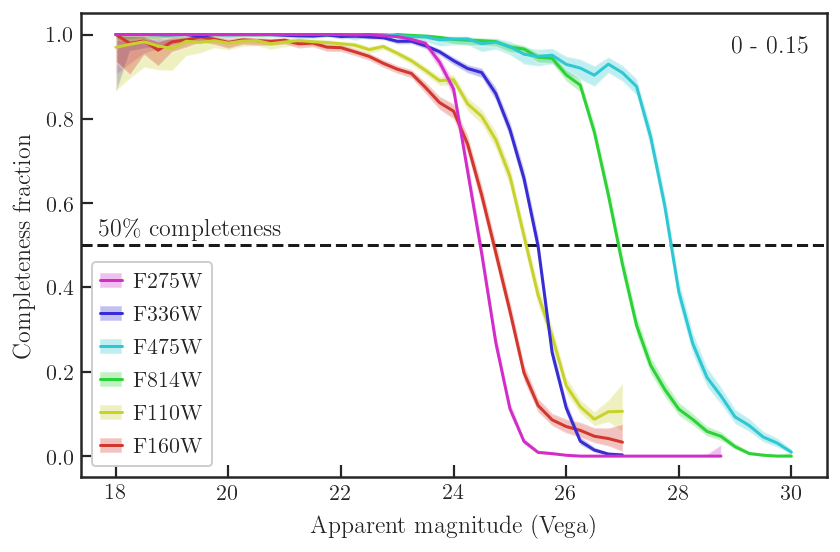

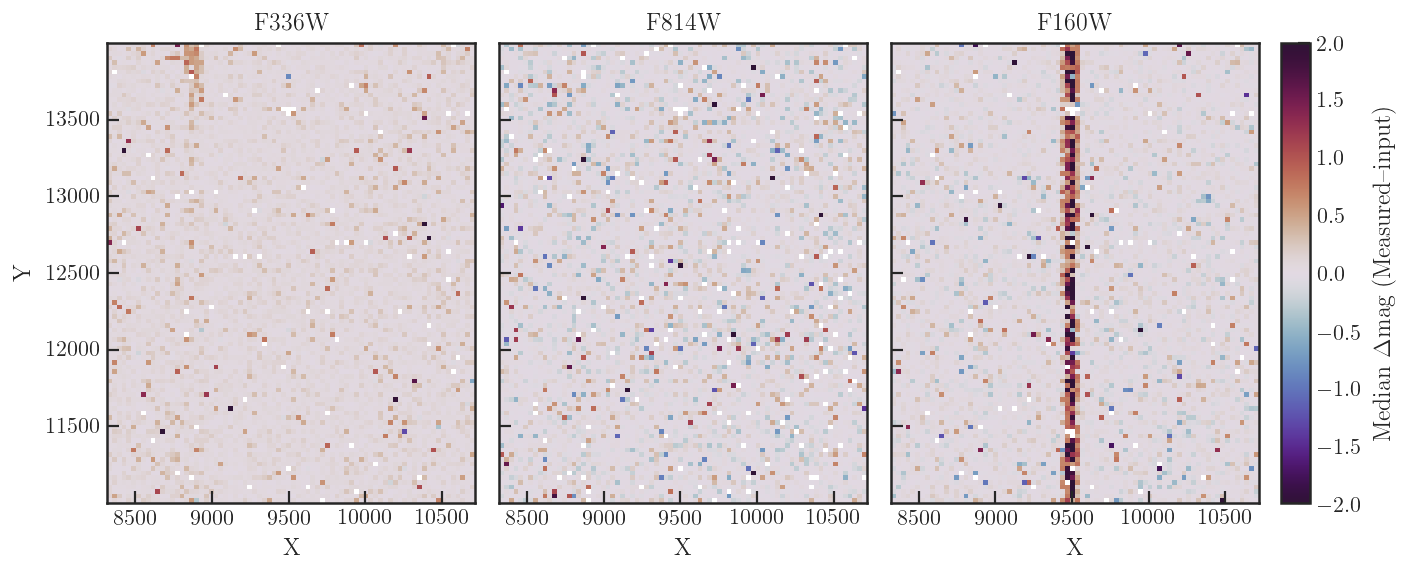

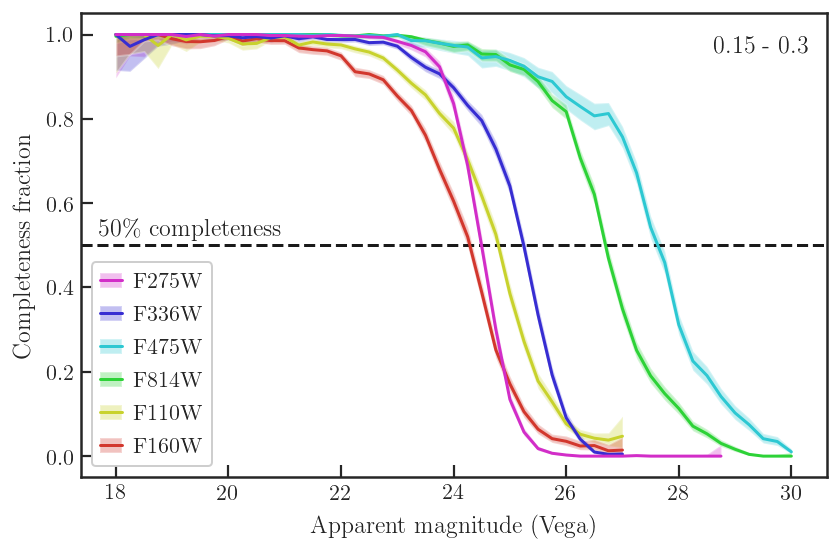

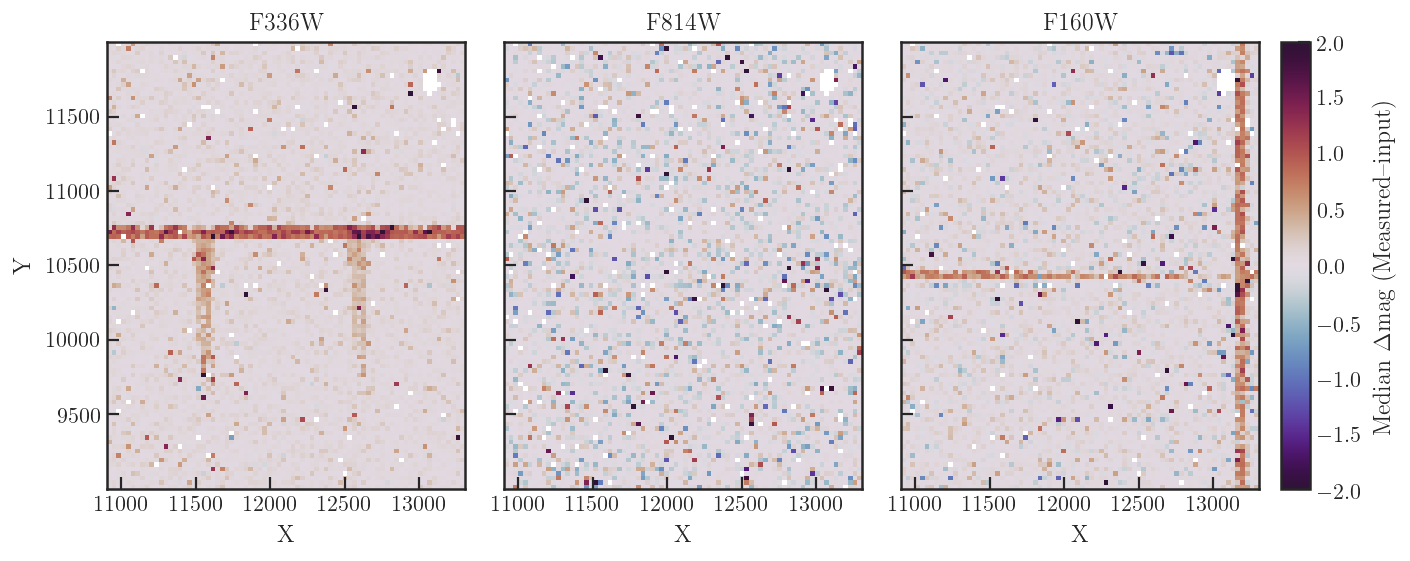

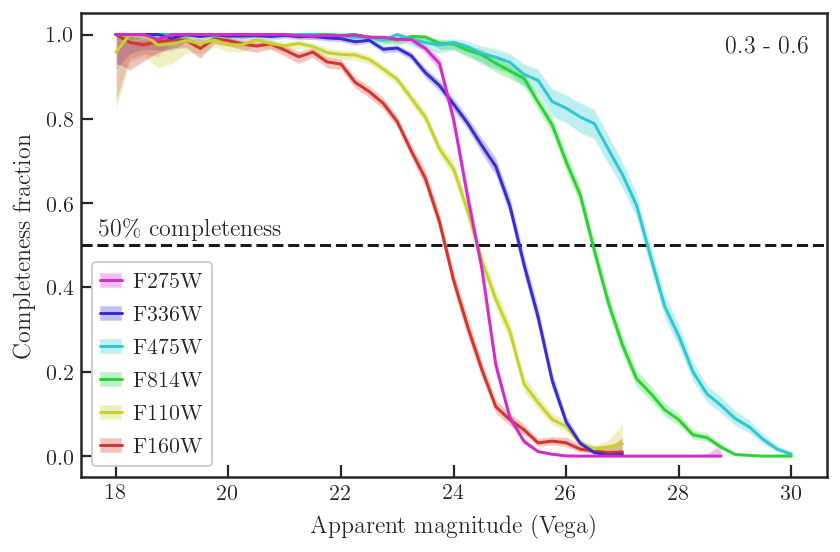

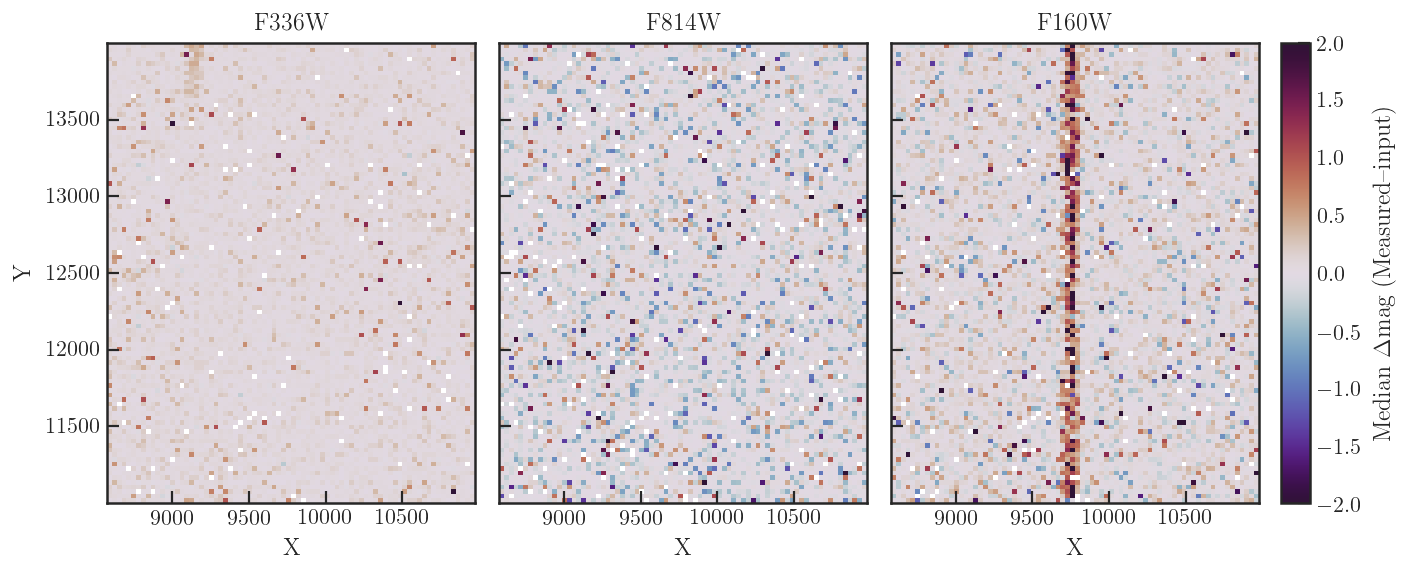

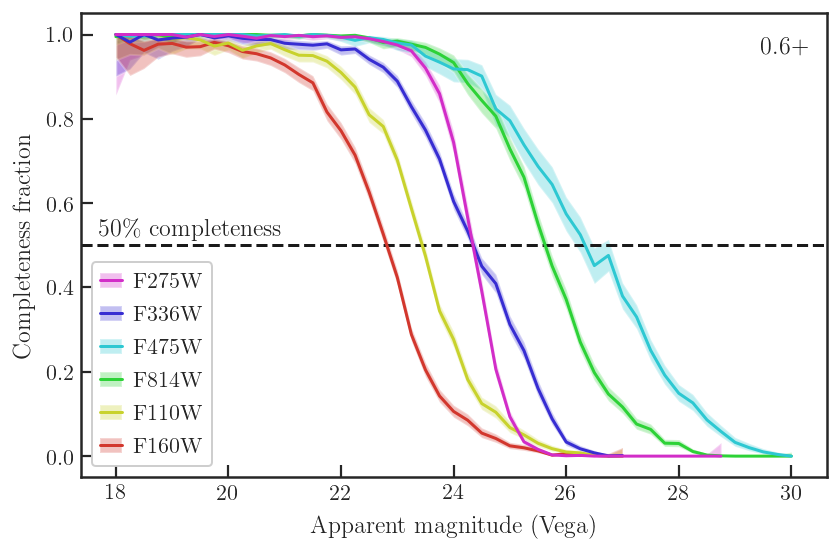

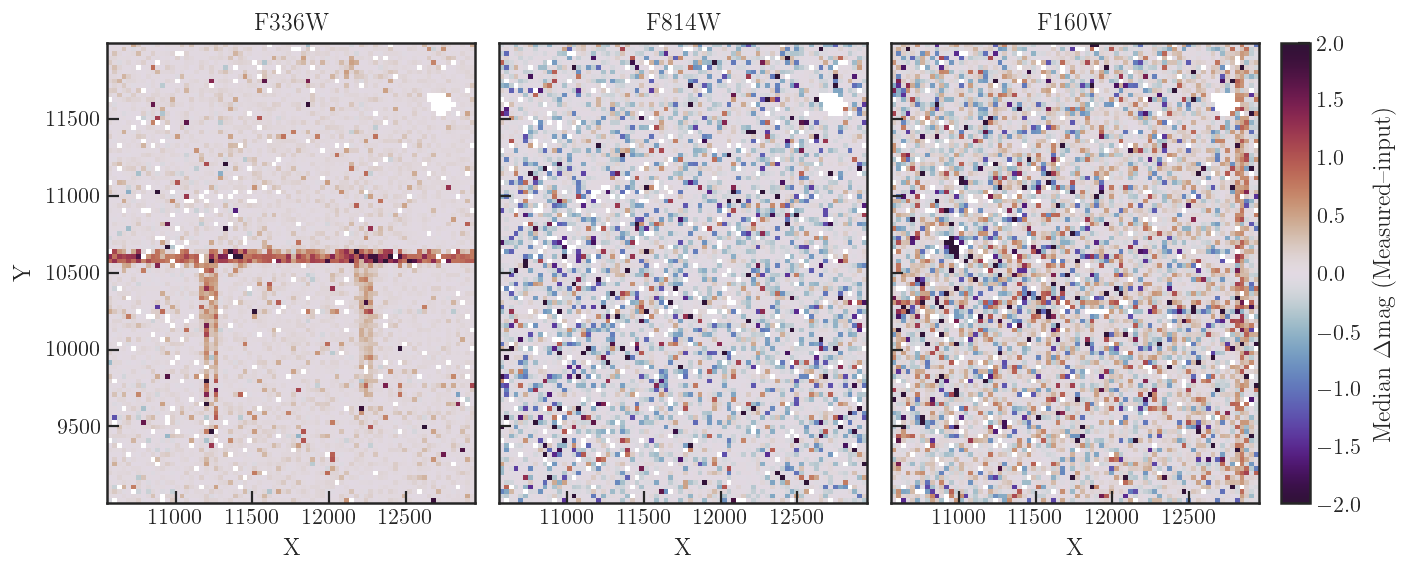

In [349]:
infiles = glob.glob('../artstars/M33_B0[1-2]_??_fake_final.hdf5')
print(infiles)
densities = [(0, 0.15), (0.15, 0.3), (0.3, 0.6), (0.6, 10)]

ds = read_artstars(glob.glob('../artstars/M33_B0[1-2]_??_fake_final.hdf5'))
density_bin = np.zeros(ds.length())
for i, (d0, d1) in enumerate(densities):
    ds.select(f'(DENSITY >= {d0}) & (DENSITY < {d1})', name=f'd{i}')
    density = ds.evaluate_selection_mask(f'd{i}')
    density_bin += density*(i+1)
ds.add_column('DENSITY_BIN', density_bin)

filters = ['F275W','F336W','F475W','F814W','F110W','F160W']
df_comp = pd.DataFrame(columns=filters, index=[1,2,3,4], data=np.nan)
for i, (infile, density) in enumerate(zip(infiles, densities)):
    fig, ax, comp = plot_completeness(ds[ds.DENSITY_BIN == i+1])
    for f in ['F275W','F336W','F475W','F814W','F110W','F160W']:
        p50_idx = (comp[f] - 0.5).abs().idxmin()
        df_comp.loc[i+1, f] = p50_idx
    txt = f'{density[0]} - {density[1]}' if (density[1] < 5) else f'{density[0]}+'
    ax.text(0.975, 0.95, txt, va='top', ha='right', transform=ax.transAxes)
    ax.text(0.025, 0.51, '50\% completeness', va='bottom', ha='left', transform=ax.transAxes)
    name = infile.split('/')[-1].split('_fake')[0]
    fig.tight_layout()
    fig.savefig(f'survey_paper_figures/{name}_comp.pdf', bbox_inches='tight')
    fig = plot_xy_delta(read_artstars(infile))
    fig.savefig(f'survey_paper_figures/{name}_xy_delta.pdf', bbox_inches='tight')
df_comp.set_index(pd.Index([0.075, 0.225, 0.45, 0.75]), inplace=True)
df_comp

Text(0, 0.5, '50\\% completeness limit')

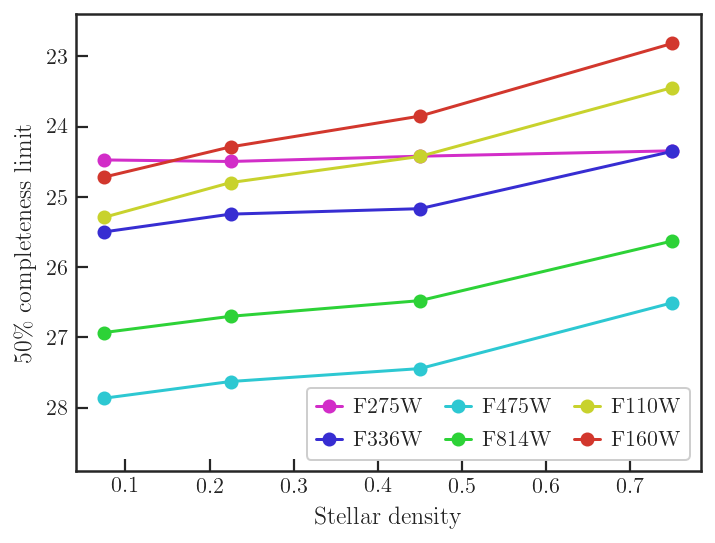

In [351]:
with sns.color_palette(sns.hls_palette(6, l=0.5)[::-1]):
    fig, ax = plt.subplots(1, figsize=(5.6, 4.2))
    df_comp[filters].plot(linestyle='-', marker='o', figure=fig, ax=ax, legend=False)
ax.set_ylim(28.9, 22.4)
ax.legend(ncol=3, columnspacing=1, loc='lower right')
ax.set_xlabel('Stellar density')
ax.set_ylabel('50\% completeness limit')

In [432]:
df_comp['bin_lo'] = [0, 0.15, 0.3, 0.6]
df_comp['bin_hi'] = [0.15, 0.3, 0.6, 10]
df_comp.reset_index()

,index,F275W,F336W,F475W,F814W,F110W,F160W,bin_lo,bin_hi
0,0.075,24.473961,25.498028,27.865481,26.930552,25.289934,24.717392,0.00,0.15
1,0.225,24.496178,25.245384,27.627924,26.699789,24.796371,24.288204,0.15,0.30
2,0.450,24.420971,25.167907,27.444091,26.476786,24.423633,23.850180,0.30,0.60
3,0.750,24.344203,24.351072,26.506514,25.627385,23.443784,22.814592,0.60,10.00


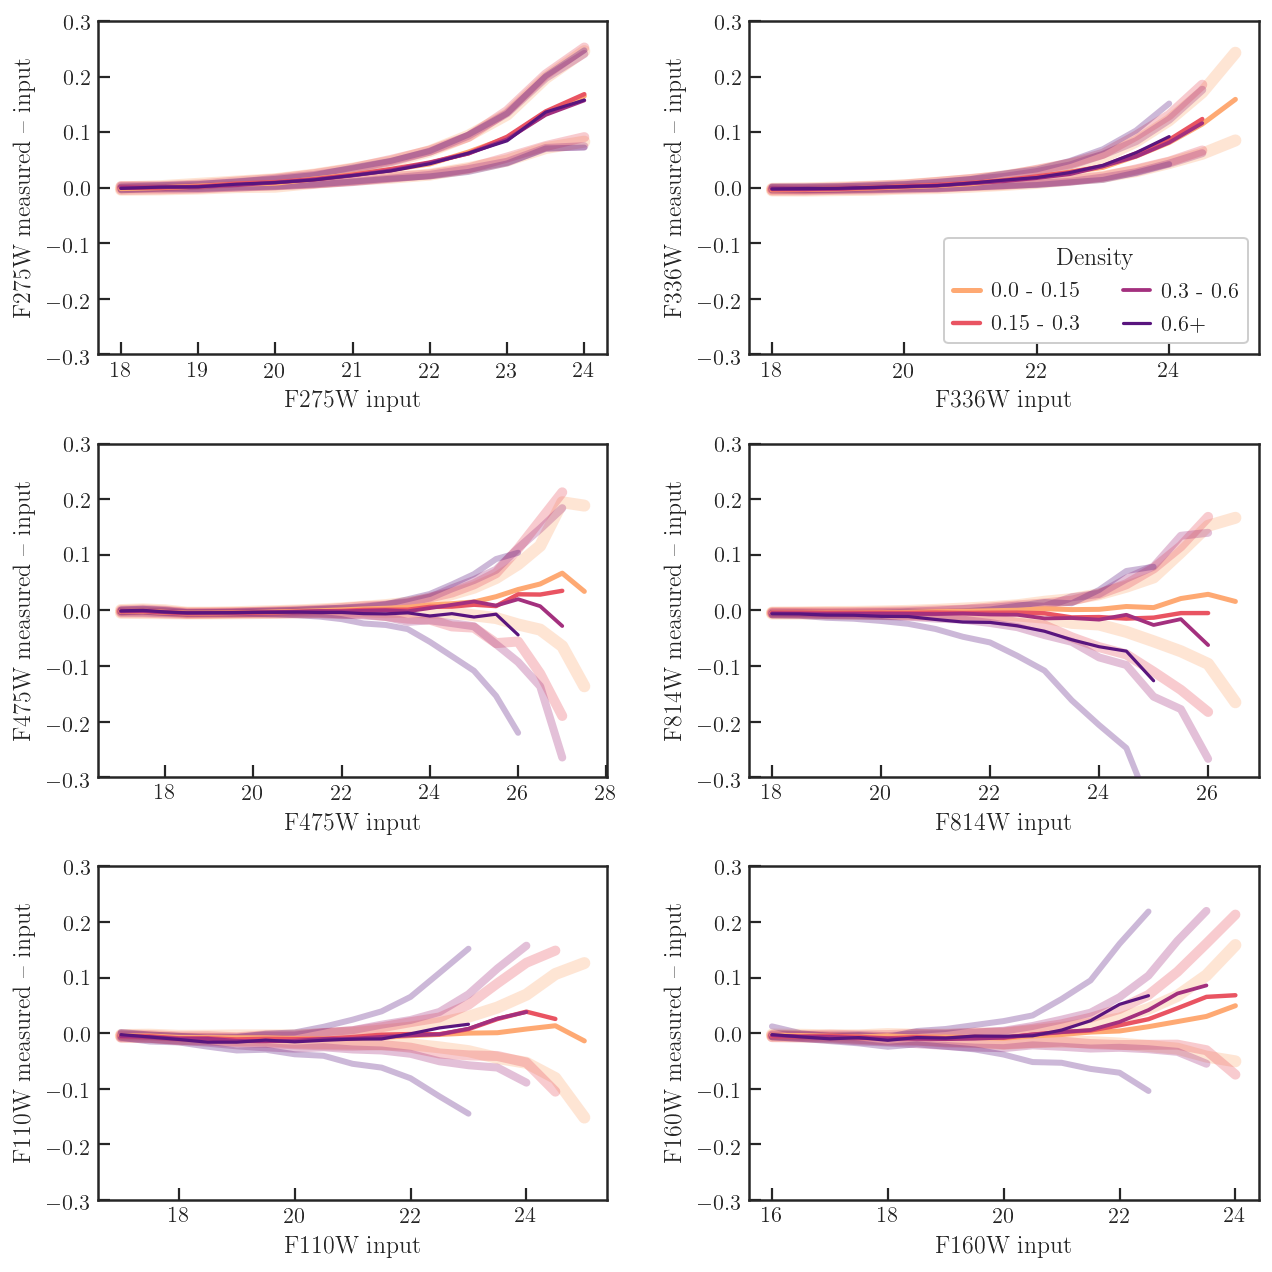

In [484]:
def myround(x, n=0.5):
    return np.round(x/n)*n

def plot_bias(ds, filters=filters, df_comp=df_comp.reset_index()):
    fig, axes = plt.subplots(3, 2, figsize=(9, 9))
    axes = axes.ravel()
    for i, filt in enumerate(filters):
        ax = axes[i]
        pmin = 0.2 if (filt in ['F110W', 'F160W', 'F336W']) else 0.5 if (filt == 'F275W') else 5
        x0 = myround(ds.percentile_approx(f'{filt}_IN', pmin, selection=f'{filt}_detected'))
        for j in df_comp.index.values:
            density = df_comp.loc[j, ['bin_lo','bin_hi']].values
            txt = f'{density[0]} - {density[1]}' if (density[1] < 5) else f'{density[0]}+'
            x = np.arange(x0-0.75, myround(df_comp.loc[j, filt]), 0.5)
            shape_kwargs = dict(limits=[x.min(), x.max()], shape=len(x)-1)
            ds.select(f'{filt}_detected & ({filt}_IN < {x.max()}) & (DENSITY_BIN == {j+1})',
                      name=f'{filt}_sc')
            bc = ds.bin_centers(f'{filt}_IN', **shape_kwargs)
            p25, p50, p75 = ds.percentile_approx(f'{filt}_DELTA', [32, 50, 68], 
                                                 binby=f'{filt}_IN', selection=f'{filt}_sc',
                                                 **shape_kwargs)
            l0, = ax.plot(bc, p50, lw=2.5-(0.3*j), zorder=1000+j, label=txt)
            ax.plot(bc, p25, alpha=0.3, lw=6-j, color=l0.get_color(), zorder=j)
            ax.plot(bc, p75, alpha=0.3, lw=6-j, color=l0.get_color(), zorder=j)
        ax.set_ylim(-0.3, 0.3)
        ax.set_xlabel(f'{filt} input')
        ax.set_ylabel(f'{filt} measured -- input')
        if filt == 'F336W':
            ax.legend(loc='lower right', ncol=2, title='Density')
    fig.tight_layout(w_pad=2, h_pad=1)
    return fig

with sns.color_palette(sns.color_palette('magma_r', 10)[1::2]):
    fig = plot_bias(ds)
    fig.savefig('survey_paper_figures/ast_bias_uncertainty.pdf')

In [223]:
# import pickle
# from astropy.wcs import WCS
# from astropy.io import fits

# infiles = glob.glob('../artstars/M33_B0[1-2]_??_fake_cor.hdf5')

# with open('../kde/kde.pkl', 'rb') as file:
#     kde = pickle.load(file)
    
# def pix2world(x, y):
#     return w.all_pix2world(np.c_[x,y], 0.5)

# def world2pix(ra, dec):
#     return w.all_world2pix(np.c_[ra,dec],0)

# for infile in infiles:
#     name = infile.split('/')[-1].split('_fake')[0]
#     w = WCS(fits.Header.fromtextfile(f'../{name}/{name}_F475W_drc_wcs.txt'))
#     ds = vaex.open(infile)
#     ra, dec = np.require(ds.apply(pix2world, arguments=[ds.X_IN, ds.Y_IN],
#                                   vectorize=True).evaluate().T,
#                          requirements=['C_CONTIGUOUS'])
#     ds.add_column('RA', ra)
#     ds.add_column('DEC', dec)
#     density = kde.score_samples(np.c_[ra, dec])
#     ds.add_column('DENSITY', np.exp(density)/60)
#     ds.export_hdf5(infile.replace('_cor','_final'))
#     #print(name, 'X:', ds.minmax('X_IN').round(), 'Y:', ds.minmax('Y_IN').round())